We scanned *a lot* of teeth for the ZMK guys and gals.
Let's generate overview images of them

In [76]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
from tqdm import notebook
import skimage.filters
import skimage.morphology
import skimage.segmentation
import scipy.ndimage

In [77]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:41515/status"


In [78]:
# https://stackoverflow.com/a/62242245/323100
import warnings
warnings.filterwarnings('ignore')

In [79]:
# Set up figure defaults
# Display all images in b&w and with 'nearest' interpolation
plt.rc('image', cmap='gray', interpolation='nearest')
# Resize figures
plt.rcParams['figure.figsize'] = (16, 9)

In [80]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [81]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [82]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/ZMK/Output/f556e12


In [83]:
# Display all plots identically
lines = 11
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [84]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'ZMK')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/ZMK


In [85]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [86]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [87]:
# Look only for folders: https://stackoverflow.com/a/38216530
Data['Folder'] = glob.glob(os.path.join(Root, 'ToothBattallion', '*' + os.path.sep))

In [88]:
print('We found %s tooth folders in %s' % (len(Data), Root))

We found 4 tooth folders in /media/habi/Fast_SSD/ZMK


In [89]:
# We could do it in a list comprehension, but then it fails if we're still scanning a tooth
# Data['LogFile'] = [sorted(glob.glob(os.path.join(f, '*.log')))[0] for f in Data['Folder']]
for c, row in Data.iterrows():
    try:
        Data.at[c, 'LogFile'] = sorted(glob.glob(os.path.join(row['Folder'], '*.log')))[0]
    except IndexError:
        print('No logfile found in %s, removing the folder temporarily' % row.Folder)
        Data.at[c, 'LogFile'] = 'scanning'
Data = Data[Data['LogFile'] != 'scanning']
Data.reset_index(drop=True, inplace=True)
print('We have %s tooth folders to work with' % (len(Data)))

We have 4 tooth folders to work with


In [90]:
Data['Sample'] = [os.path.splitext(os.path.basename(l))[0] for l in Data['LogFile']]

In [91]:
# Proper sorting *with* leading zeros :)
Data.sort_values(by=['Sample'], inplace=True)

In [92]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*rec*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [93]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s tooth folders with reconstructions' % (len(Data)))

We have 4 tooth folders with reconstructions


In [94]:
# # Temporarily drop some data
# Data = Data[:5]
# print('We are currently working with a subset of %s teeth' % len(Data))

In [95]:
print('In total, we have',
      Data['Number of reconstructions'].sum(),
      'reconstructions over all the 104 datasets')

In total, we have 12058 reconstructions over all the 104 datasets


In [96]:
print('On average, each tooth has about',
      int(round(Data['Number of reconstructions'].mean())),
      'reconstructions.')

On average, each tooth has about 3014 reconstructions.


In [97]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [98]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [99]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
if len(Data['Voxelsize'].round(2).unique()) > 1:
    print('We scanned the teeht with %s different voxel sizes' % len(Data['Voxelsize'].round(2).unique()))
    for vs in sorted(Data['Voxelsize'].round(2).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], 2):
                print(row.Sample, end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s.' % Data['Voxelsize'].unique()[0])

We scanned all datasets with equal voxel size, namely 9.999986.


In [100]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [101]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                stacks = int(line.split('=')[1])
    return(stacks)

In [102]:
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

In [103]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1]
    return(time)

In [104]:
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]

In [105]:
def get_numproj(logfile):
    """How many projections did we record?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number' in line and 'Files' in line:
                numproj = int(line.split('=')[1])
    return(numproj)

In [106]:
Data['Number of Projections'] = [get_numproj(log) for log in Data['LogFile']]

In [107]:
Data.head()

,Folder,LogFile,Sample,Reconstructions,Number of reconstructions,Voxelsize,Stacks,Scan time,Number of Projections
0,/media/habi/Fast_SSD/ZMK/ToothBattallion/7/,/media/habi/Fast_SSD/ZMK/ToothBattallion/7/Too...,Tooth007,[/media/habi/Fast_SSD/ZMK/ToothBattallion/7/re...,3002,9.999986,5,0h:40m:33s\n,482
1,/media/habi/Fast_SSD/ZMK/ToothBattallion/45/,/media/habi/Fast_SSD/ZMK/ToothBattallion/45/To...,Tooth045,[/media/habi/Fast_SSD/ZMK/ToothBattallion/45/r...,2585,9.999986,5,0h:39m:51s\n,482
2,/media/habi/Fast_SSD/ZMK/ToothBattallion/66/,/media/habi/Fast_SSD/ZMK/ToothBattallion/66/To...,Tooth066,[/media/habi/Fast_SSD/ZMK/ToothBattallion/66/r...,2568,9.999986,5,0h:39m:43s\n,482
3,/media/habi/Fast_SSD/ZMK/ToothBattallion/99/,/media/habi/Fast_SSD/ZMK/ToothBattallion/99/To...,Tooth099,[/media/habi/Fast_SSD/ZMK/ToothBattallion/99/r...,3903,9.999986,5,0h:39m:49s\n,482


In [108]:
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]

In [109]:
if len(Data['Grayvalue'].unique()) > 1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c, row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(row.Sample, end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed all datasets with equal maximum gray value, namely 0.18.


In [110]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, c, row100)) for pip in Data['PreviewImagePath']]

In [111]:
# plt.rcParams['figure.figsize'] = (10, 20)

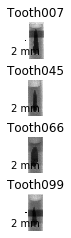

In [112]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [113]:
# plt.rcParams['figure.figsize'] = (16, 9)

In [114]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%3s/%3s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [115]:
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [116]:
# Load the reconstructions as zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [117]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [118]:
def cropper(image, despeckle=True, verbose=False, threshold=55):
    '''Crop array to biggest item in it'''
    dimensions = len(image.shape)
    print('Cropping %s-dimensional image' % dimensions)
    # Threshold
    thresholded = image > threshold
    if despeckle:
        if verbose:
            print('Removing small objects')
        despeckled = skimage.util.apply_parallel(skimage.morphology.remove_small_objects,
                                                 thresholded,
                                                 extra_keywords={'min_size': 10**dimensions})
    # Find biggest object
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html
    if verbose:
        print('Finding objects')
    if despeckle:
        cropdimensions = scipy.ndimage.find_objects(despeckled)[0]
    else:
        cropdimensions = scipy.ndimage.find_objects(thresholded)[0]
    if verbose:
        print('Cutting the image down to')
        for c, cd in enumerate(cropdimensions):
            print('\t- %s: %s' % (c, cd))
        if dimensions > 2:
            # Calculate cardinal direction MIPs
            MIPs = [image.max(axis=d) for d, direction in notebook.tqdm(enumerate(directions),
                                                                                  desc='Calculating MIPs',
                                                                                  total=len(directions))]
            for d, direction in enumerate(directions):
                plt.subplot(1, dimensions, d + 1)
                plt.imshow(MIPs[d], alpha=0.618)
                plt.imshow(dask.array.ma.masked_less(MIPs[d]>threshold, 1),
                           alpha=0.309,
                           cmap='viridis_r')
                if d == 0:
                    plt.axhline(cropdimensions[1].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[1].start)
                    plt.axhline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[1].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)
                elif d == 1:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)                    
                elif d == 2:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[1].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[1].start)
                    plt.axvline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[1].stop)                                        
                plt.title('%s MIP' % direction)
                plt.legend(loc='lower right')
        else:
            plt.subplot(121)
            plt.imshow(image, alpha=0.618)
            plt.imshow(dask.array.ma.masked_less(thresholded, 1), alpha=0.618, cmap='viridis_r')
            plt.axhline(cropdimensions[0].start, c=seaborn.color_palette()[0], label=cropdimensions[0].start)
            plt.axhline(cropdimensions[0].stop, c=seaborn.color_palette()[1], label=cropdimensions[0].stop)
            plt.axvline(cropdimensions[1].start, c=seaborn.color_palette()[2], label=cropdimensions[1].start)
            plt.axvline(cropdimensions[1].stop, c=seaborn.color_palette()[3], label=cropdimensions[1].stop)
            plt.title('Original image with thresholded overlay')
            plt.legend(loc='lower right')
            plt.subplot(122)
            plt.imshow(image[cropdimensions])
            plt.title('Output')
        plt.show()
    if verbose:
        print('Cropped image from %s to %s' % (image.shape, image[cropdimensions].shape))
    return(image[cropdimensions])

In [119]:
# # Test cropping function
# img = Reconstructions[3][1800:]
# Cropped = cropper(img, verbose=True, despeckle=True, threshold=55)
# for c, direction in enumerate(directions):
#     plt.subplot(1,3,c+1)    
#     if 'Axial' in direction:
#         plt.imshow(Cropped[Cropped.shape[0] // 2])
#     if 'Sagittal' in direction:
#         plt.imshow(Cropped[:, Cropped.shape[1] // 2, :])
#     if 'Coronal' in direction:
#         plt.imshow(Cropped[:, :, Cropped.shape[2] // 2])

In [120]:
# Crop the reconstructions and save them out as .zarr files, too
Data['OutputNameRecCrop'] = [os.path.join(f, sample + '_rec_crop.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving cropped .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRecCrop']):
        print('%3s/%3s: Saving to %s' % (c + 1,
                                         len(Data),
                                         row['OutputNameRecCrop'][len(Root):]))
        # Calculate crop with our function and directly write to ZARR file
        cropper(Reconstructions[c],
                verbose=True,
                despeckle=True).to_zarr(row['OutputNameRecCrop'],
                                        overwrite=True,
                                        compressor=Blosc(cname='zstd',
                                                         clevel=3,
                                                         shuffle=Blosc.BITSHUFFLE))        

In [121]:
# Load the cropped zarr arrays as reconstructions
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRecCrop']]

In [122]:
# Save out cropped rec slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out cropped recs',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'rec_crop'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(Reconstructions[c]),
                                total=len(Reconstructions[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'rec_crop', str(row.Sample) + 'rec_crop_%08d.png' % d)
        if not os.path.exists(filename):
            imageio.imsave(filename, rec)

In [123]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Reconstructions[c].shape[0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Reconstructions[c].shape[1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Reconstructions[c].shape[2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

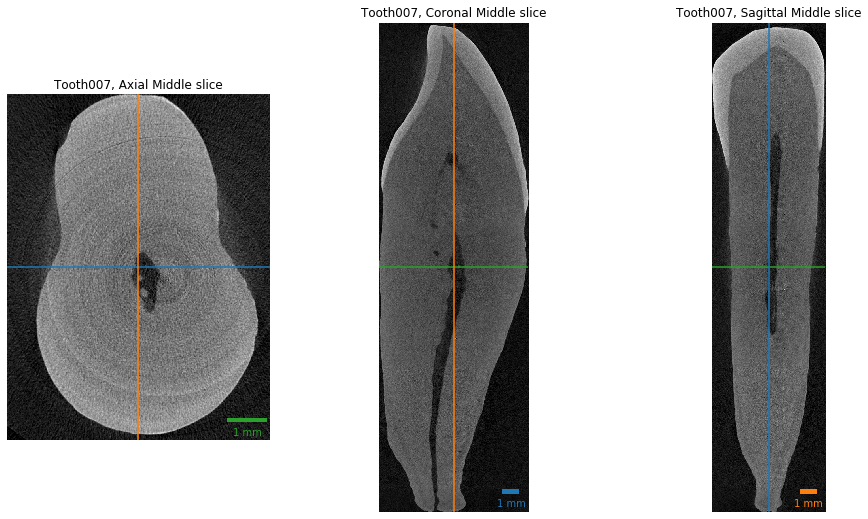

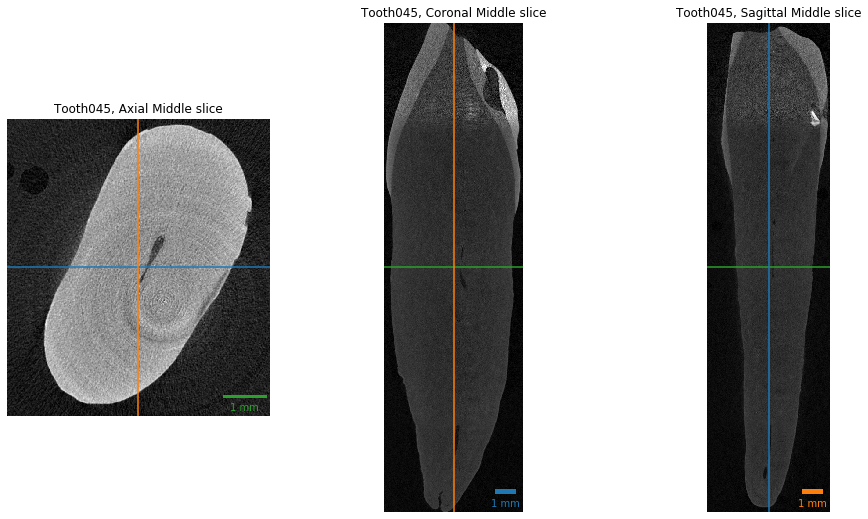

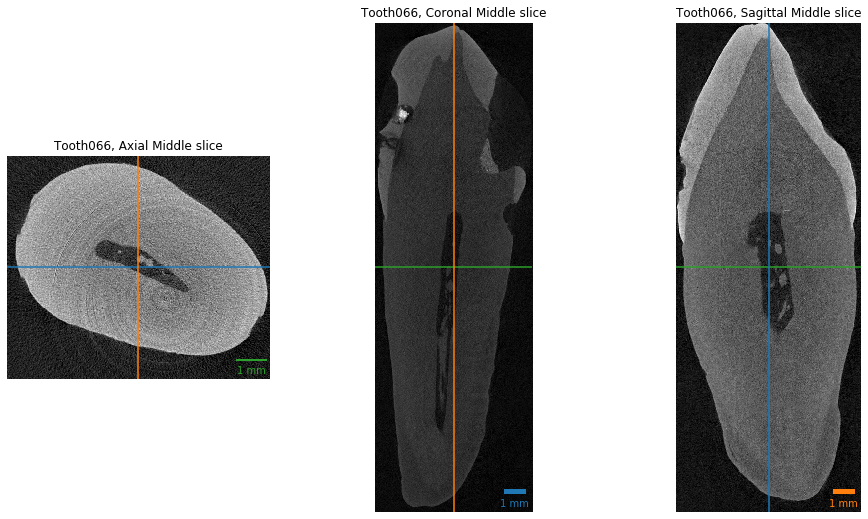

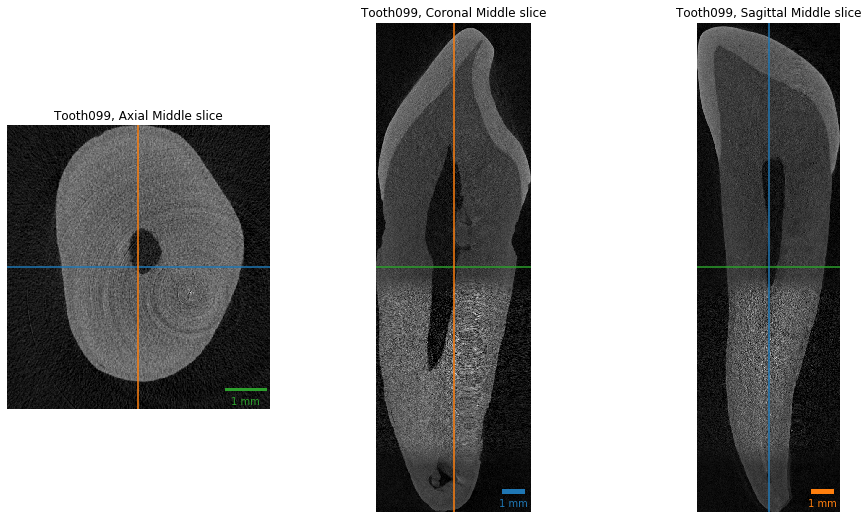

In [124]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png')
# if not os.path.exists(outfilepath):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        if d == 0:
            plt.axhline(Reconstructions[c].shape[1] // 2, c=seaborn.color_palette()[0])
            plt.axvline(Reconstructions[c].shape[2] // 2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
        elif d == 1:
            plt.axhline(Reconstructions[c].shape[0] // 2, c=seaborn.color_palette()[2])
            plt.axvline(Reconstructions[c].shape[1] // 2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
        else:
            plt.axhline(Reconstructions[c].shape[0] // 2, c=seaborn.color_palette()[2])
            plt.axvline(Reconstructions[c].shape[2] // 2, c=seaborn.color_palette()[0])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
        plt.title('%s, %s' % (row['Sample'],
                              direction + ' Middle slice'))
        plt.axis('off')
    plt.savefig(outfilepath, bbox_inches='tight')
    plt.show()

In [125]:
# for c, row in Data.iterrows():
#     print(c, row.Sample, Reconstructions[c].shape)

In [126]:
# Read or calculate the directional MIPs of the cropped reconstructions
# Put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Data)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            try:
                # Generate MIP
                Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            except ZeroDivisionError:
                print('Something does not work for %s, copying uncropped MIP' % row['Sample'])
                Data.at[c, 'MIP_' + direction] = Data.at[c, 'MIP_' + direction]
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

In [127]:
# Show cropped MIPs
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving cropped MIP overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MIPs.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [128]:
# To speed up the characterization of the bottom part of the tooth
# it is necessary to have coronal/sagittal slices of the lowest ~3mm
# Lets thus extract these slices and write them to disk.

# How many slices are 3.5mm
Data['BottomSlices'] = [int(round(3500 / vs)) for vs in Data['Voxelsize']]

In [129]:
# Crop and save out bottom of tooth
Data['OutputNameBottom'] = [os.path.join(f, sample + '_rec_base.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving bottom of tooth to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameBottom']):
        print('%3s/%3s: Saving to %s' % (c + 1,
                                         len(Data),
                                         row['OutputNameBottom']))
        
        # Save out the bottom part of the tooth after cropping it to its minimal size       
        cropper(Reconstructions[c][-row.BottomSlices:],
                verbose=True, threshold=50).to_zarr(row['OutputNameBottom'],
                                      overwrite=True,
                                      compressor=Blosc(cname='zstd',
                                                       clevel=3,
                                                       shuffle=Blosc.BITSHUFFLE))

In [130]:
# Load the bottom zarr arrays
Bottoms = [dask.array.from_zarr(file) for file in Data['OutputNameBottom']]

In [131]:
# # Reslice the bottom part and write it out
# for c, row in notebook.tqdm(Data.iterrows(),
#                             desc='Saving resliced bottom part',
#                             total=len(Data)):
#     os.makedirs(os.path.join(row.Folder, 'base_reslice'),
#                 exist_ok=True)
#     # Check if we did alrady save something there
#     if not os.listdir(os.path.join(row.Folder, 'base_reslice')):
#         # Load *this* cropped rec to memory
#         Bottoms[c].compute()
#     for d in notebook.tqdm(range(Bottoms[c].shape[-1]),
#                            desc=row.Sample,
#                            leave=False):
#         filename = os.path.join(row.Folder,
#                                 'base_reslice', str(row.Sample) + 'rec_bottom_sagittal_%04d.png' % d)
#         if not os.path.exists(filename):
#             imageio.imsave(filename, Bottoms[c][:, :, d])

In [132]:
# Read or calculate the middle slices of the bottom part, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_Base_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Base.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_Base_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_Base_' + direction] = Bottoms[c][Bottoms[c].shape[0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_Base_' + direction] = Bottoms[c][:, Bottoms[c].shape[1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_Base_' + direction] = Bottoms[c][:, :, Bottoms[c].shape[2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [133]:
# Show middle slices of the base
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.Base.MiddleSlices.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_Base_' + direction])
            if d == 0:
                plt.axhline(Bottoms[c].shape[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(Bottoms[c].shape[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(Bottoms[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Bottoms[c].shape[1] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
            else:
                plt.axhline(Bottoms[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Bottoms[c].shape[2] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' Middle slice'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [134]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Base_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Base.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_Base_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_Base_' + direction] = Bottoms[c].compute().max(axis=d)
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_Base_' + direction].astype('uint8'))

In [135]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving bottom MIP overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.Base.MIPs.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_Base_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [136]:
# for file in Data['OutputNameRecCrop']:
#     print(file)
#     dask.array.from_zarr(file)

In [137]:
def get_partialpart(reconstruction, slicenumber, what='min', numberofslicesaround=50, verbose=False):
    '''
    Function to get a small part around the selected slice number.
    We select the minima to (potentially) show any accessory canals nicely
    '''
    if what == 'min':
        part = numpy.min(reconstruction[slicenumber - numberofslicesaround // 2:
                                        slicenumber + numberofslicesaround // 2],
                         axis=0)
    if what == 'max':
        part = numpy.max(reconstruction[slicenumber - numberofslicesaround // 2:
                                        slicenumber + numberofslicesaround // 2],
                         axis=0)
    if what == 'mean':
        part = numpy.mean(reconstruction[slicenumber - numberofslicesaround // 2:
                                         slicenumber + numberofslicesaround // 2],
                          axis=0)
    if not what:
        part = reconstruction[slicenumber]
    if verbose:
        plt.imshow(part)
    return(part)

dask.array<amin-aggregate, shape=(727, 855), dtype=uint8, chunksize=(727, 855), chunktype=numpy.ndarray>

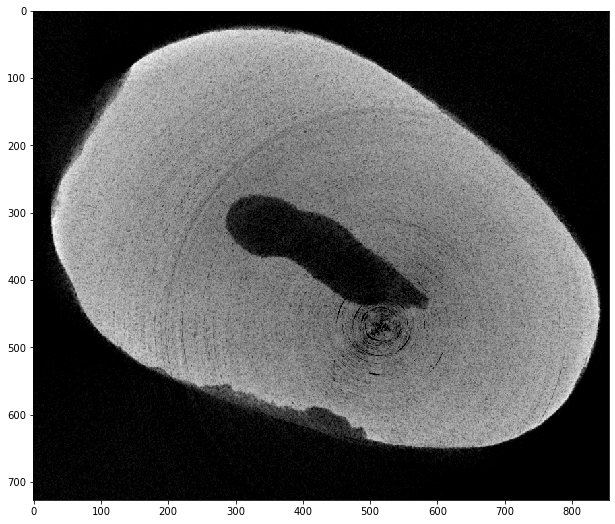

In [138]:
get_partialpart(Reconstructions[2], 999, what='min', verbose=True, numberofslicesaround=250)

dask.array<amax-aggregate, shape=(727, 855), dtype=uint8, chunksize=(727, 855), chunktype=numpy.ndarray>

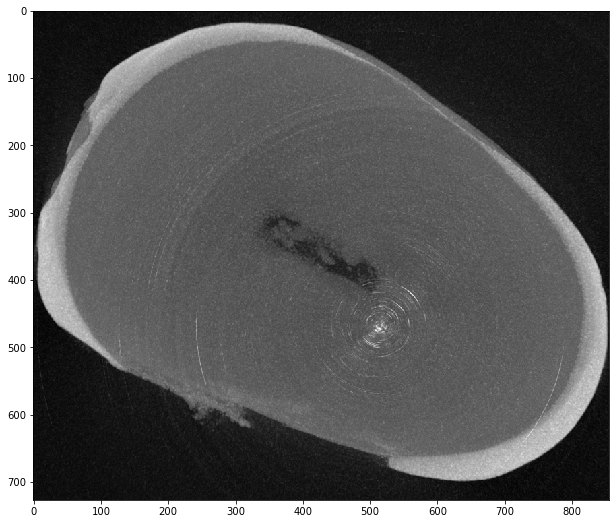

In [139]:
get_partialpart(Reconstructions[2], 999, what='max', verbose=True, numberofslicesaround=250)

dask.array<mean_agg-aggregate, shape=(727, 855), dtype=float64, chunksize=(727, 855), chunktype=numpy.ndarray>

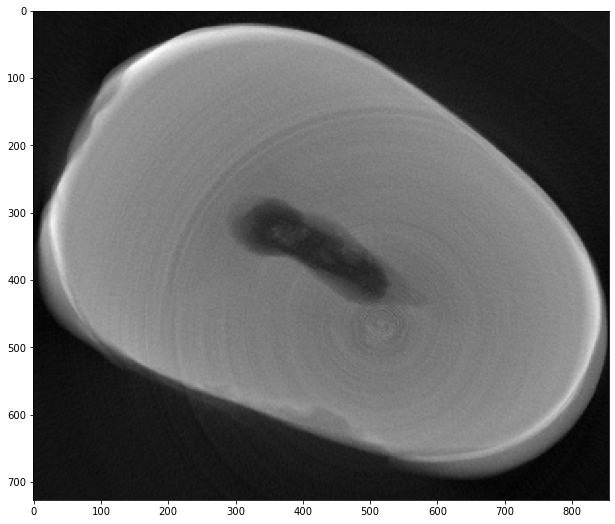

In [140]:
get_partialpart(Reconstructions[2], 999, what='mean', verbose=True, numberofslicesaround=250)

dask.array<getitem, shape=(727, 855), dtype=uint8, chunksize=(727, 855), chunktype=numpy.ndarray>

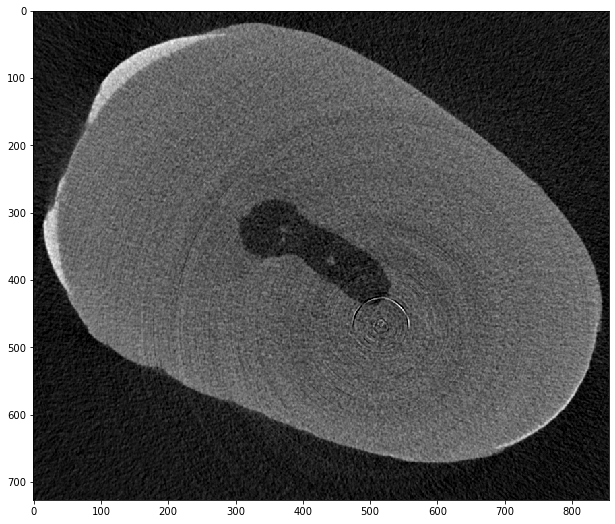

In [141]:
get_partialpart(Reconstructions[2], 999, what=None, verbose=True, numberofslicesaround=250)

In [142]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get the border of enamel/dentin.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.025)
    minima = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(minima, c='r', label='Border')
        plt.legend()
    return(minima, smoothed)

In [143]:
def splitter(whichone, top=0, bottom=50, curve=True, showregion=True, saveslices=True, verbose=False):
    '''
    According to the discussion on July 6 with Thomas & Andrea, the characterization of the pulpa is done at three levels.
    The start of the levels is at the border enamel/dentin.
    With a bit of filtering of the gray values of the MIPs along the tooth we find this border and then return three images in this region.
    We save the figure and return the four images.
    '''
    # First we need to detect the border.
    # We do this by smoothing the gray value along the tooth, calculating the difference along the axis and taking its minimum
    # This should be the border between enamel/dentin
    grayvalues = Data['MIP_Sagittal'][whichone].max(axis=1)
    if top < 1:
        # If we don't set it manually, calculate the border
        top, smoothed = get_minimum(grayvalues, verbose)
    else:
        smoothed = numpy.zeros_like(grayvalues)
    # Since we don't want the *very* bottom, we 'fake' slices extraction by generating the range,
    # splitting it in three,
    # selecting the start of each split as slices and
    # add a slice not at the very $bottom
    try:
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    except IndexError:
        print('Something went wrong with the slice calculation')
        top = 500
        curve = False
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    if verbose:
        print('The scan has %s slices' % Reconstructions[whichone].shape[0])
        print('We found the enamel/dentin border at slice %s' % top)
        print('We split the distance from slice', end=' ')
        print('%s to %s in three parts (e.g. %s//3)' % (top,
                                                        Reconstructions[whichone].shape[0],
                                                        Reconstructions[whichone].shape[0] - top))
        print('We are returning slice', end=' ')
        for i in slices[:-1]:
            print(i, end=', ')
        print('and %s for the pulpa characterization' % slices[-1])
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 4)
    fig_mip_s = fig.add_subplot(gs[:, 0])
    plt.imshow(Data['MIP_Sagittal'][whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_s.set_title('Sagittal MIP\nSlices and grey value profile')
    fig_mip_c = fig.add_subplot(gs[:, 1])
    plt.imshow(Data['MIP_Coronal'][whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data['MIP_Coronal'][whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_c.set_title('Coronal MIP\nSlices and grey value profile')
    for i in range(4):
        if i < 2:
            fig_slc = fig.add_subplot(gs[0, i + 2])
        else:
            fig_slc = fig.add_subplot(gs[1, i])
        if showregion:
            nsa = 40
            plt.imshow(get_partialpart(Reconstructions[whichone],
                                       slices[i],
                                       numberofslicesaround=nsa))
            fig_slc.set_title('Minima of %s slices around slice %s' % (nsa, slices[i]))
        else:
            plt.imshow(Reconstructions[whichone][slices[i]])
            fig_slc.set_title('Slice %s' % slices[i])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.axis('off')
    if verbose:
        print('Saving figure to %s' % os.path.join(Data.Folder[whichone],
                                                   Data.Sample[whichone] + 'ExtractedSlices.png'))
    plt.suptitle(Data.Sample[whichone])
    plt.savefig(os.path.join(Data.Folder[whichone],
                             Data.Sample[whichone] + '.ExtractedSlices.png'))
    plt.show()
    if saveslices:
        # Save out the slices if requested
        for slc in slices:
            imageio.imsave(os.path.join(Data.Folder[whichone],
                                        Data.Sample[whichone] + '.ExtractedSlice.%04d.png' % slc),
                           Reconstructions[whichone][slc])
    return(Reconstructions[whichone][slices])

In [144]:
for c, row in Data.iterrows():
    if not os.path.exists(os.path.join(row.Folder, row.Sample + '.ExtractedSlices.png')):
        print('%3s/%3s: Detecting enamel/dentin border for %s' % (c + 1, len(Data), row.Sample))
        splitter(c)

In [145]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(0, top=850)

In [147]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(15, top=925)

In [148]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(17, top=925)

In [ ]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(19, top=925)

In [ ]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(21, top=800)

In [ ]:
# # Doesn't work automatically, let's do it manually
# _ = splitter(23, top=1100)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(30, top=1100)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(31, top=750)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(32, top=1050)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(33, top=725)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(39, top=866)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(43, top=800)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(44, top=950)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(45, top=900)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(50, top=750)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(52, top=1050)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(54, top=1060)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(57, top=900)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(58, top=800)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(59, top=750)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(61, top=1111)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(65, top=1050)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(68, top=950)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(70, top=900)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(74, top=1000)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(78, top=850)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(81, top=1050)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(89, top=800)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(92, top=750)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(93, top=850)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(94, top=800)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(97, top=800)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(98, top=900)

In [ ]:
def splitter_uncropped(whichone, top=0, bottom=50, curve=True, showregion=True, saveslices=True, verbose=False):
    '''
    According to the discussion on July 6 with Thomas & Andrea, the characterization of the pulpa is done at three levels.
    The start of the levels is at the border enamel/dentin.
    With a bit of filtering of the gray values of the MIPs along the tooth we find this border and then return three images in this region.
    We save the figure and return the four images.
    '''
    # First we need to detect the border.
    # We do this by smoothing the gray value along the tooth, calculating the difference along the axis and taking its minimum
    # This should be the border between enamel/dentin
    grayvalues = Data.MIP_Sagittal[whichone].max(axis=1)
    if top < 1:
        # If we don't set it manually, calculate the border
        top, smoothed = get_minimum(grayvalues, verbose)
    else:
        smoothed = numpy.zeros_like(grayvalues)
    # Since we don't want the *very* bottom, we 'fake' slices extraction by generating the range,
    # splitting it in three, selecting the start of each split as slices and add a slice not at the very $bottom
    try:
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    except IndexError:
        print('Something went wrong with the slice calculation')
        top = 500
        curve = False
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    if verbose:
        print('The scan has %s slices' % Reconstructions[whichone].shape[0])
        print('We found the enamel/dentin border at slice %s' % top)
        print('We split the distance from slice', end=' ')
        print('%s to %s in three parts (e.g. %s//3)' % (top,
                                                        Reconstructions[whichone].shape[0],
                                                        Reconstructions[whichone].shape[0] - top))
        print('We are returning slice', end=' ')
        for i in slices[:-1]:
            print(i, end=', ')
        print('and %s for the pulpa characterization' % slices[-1])
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 4)
    fig_mip_s = fig.add_subplot(gs[:, 0])
    plt.imshow(Data.MIP_Sagittal[whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data.MIP_Sagittal[whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data.MIP_Sagittal[whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_s.set_title('Sagittal MIP\nSlices and grey value profile')
    fig_mip_c = fig.add_subplot(gs[:, 1])
    plt.imshow(Data.MIP_Coronal[whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data.MIP_Sagittal[whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data.MIP_Sagittal[whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_c.set_title('Coronal MIP\nSlices and grey value profile')
    for i in range(4):
        if i < 2:
            fig_slc = fig.add_subplot(gs[0, i + 2])
        else:
            fig_slc = fig.add_subplot(gs[1, i])
        if showregion:
            nsa = 40
            plt.imshow(get_partialpart(Reconstructions[whichone],
                                       slices[i],
                                       numberofslicesaround=nsa))
            fig_slc.set_title('Minima of %s slices around slice %s' % (nsa, slices[i]))
        else:
            plt.imshow(Reconstructions[whichone][slices[i]])
            fig_slc.set_title('Slice %s' % slices[i])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.axis('off')
    if verbose:
        print('Saving figure to %s' % os.path.join(Data.Folder[whichone],
                                                   Data.Sample[whichone] + 'ExtractedSlices.png'))
    plt.suptitle(Data.Sample[whichone])
    plt.savefig(os.path.join(Data.Folder[whichone],
                             Data.Sample[whichone] + '.ExtractedSlices.png'))
    plt.show()
    if saveslices:
        # Save out the slices if requested
        for slc in slices:
            imageio.imsave(os.path.join(Data.Folder[whichone],
                                        Data.Sample[whichone] + '.ExtractedSlice.%04d.png' % slc),
                           Reconstructions[whichone][slc])
    return(Reconstructions[whichone][slices])

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter_uncropped(28, top=1000, bottom=200)

In [ ]:
# Doesn't work automatically, let's do it manually
_ = splitter(76, top=1000)

In [149]:
def pulponator(image, verbose=False):
    '''Function to extract the pulpa from the tooth'''
    # Load image into memory (thresholding et al. does not work on Dask array)
    # https://github.com/dask/dask-image/issues/100
    image = image.compute()
    # Very crudely threshold the tooth from the background
    thresholded = image > skimage.filters.threshold_otsu(image)
    # The thresholded tooth is not the only feature in the image
    # If we remove the border on the inverted image, we get the stuff that is *not* connected to the border
    stuffinside = skimage.segmentation.clear_border(thresholded == False)
    # Let's remove some speckles (stuff larger than 16 px is left)
    # These are small speckles left over from the thresholding
    speckleless = skimage.morphology.remove_small_objects(stuffinside, min_size=8**2)
    # Now close holes in the pulpa region
    pulpa = skimage.morphology.remove_small_holes(speckleless, area_threshold=10**2)
    if verbose:
        plt.subplot(141)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Input image')
        plt.subplot(142)
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(thresholded, 0), cmap='viridis_r')
        plt.title('Thresholded')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(stuffinside, 0), cmap='viridis_r')
        plt.title('Uncleaned pulpa')
        plt.axis('off')
        plt.subplot(144)
        plt.axis('off')
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(pulpa, 0), cmap='viridis_r')
        plt.title('Cleaned pulpa over original')
        plt.axis('off')
        plt.show()
    return(pulpa)

In [150]:
# rec = Reconstructions[99][666]
# _=pulponator(rec, verbose=True)

In [151]:
# Extract pulpa from the teeth
Data['OutputNamePulpa'] = [os.path.join(f, sample + '_pulpa.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting pulpa, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNamePulpa']):
        print('%3s/%3s: Extracting pulpa and saving to %s' % (c + 1,
                                                              len(Data),
                                                              row['OutputNamePulpa'][len(Root):]))
        Pulpa = [pulponator(rec) for rec in Reconstructions[c]]
        Pulpa = dask.array.stack(Pulpa[:])
        Pulpa.to_zarr(row['OutputNamePulpa'],
                      overwrite=True,
                      compressor=Blosc(cname='zstd',
                                       clevel=3,
                                       shuffle=Blosc.BITSHUFFLE))

  1/  4: Extracting pulpa and saving to /ToothBattallion/7/Tooth007_pulpa.zarr
  2/  4: Extracting pulpa and saving to /ToothBattallion/45/Tooth045_pulpa.zarr
  3/  4: Extracting pulpa and saving to /ToothBattallion/66/Tooth066_pulpa.zarr
  4/  4: Extracting pulpa and saving to /ToothBattallion/99/Tooth099_pulpa.zarr



In [152]:
# Load the pupla zarr arrays
Pulpas = [dask.array.from_zarr(file) for file in Data['OutputNamePulpa']]

In [153]:
# Save out the pulpa slices
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out pulpa slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'pulpa'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(Pulpas[c]),
                                desc=row.Sample,
                                total=len(Pulpas[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'pulpa', str(row.Sample) + 'pulpa_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8'))

KeyboardInterrupt: 

In [ ]:
# 3D-Display

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
# import itkwidgets
# from itkwidgets import view

In [ ]:
# whichone = 44
# Data.Sample[whichone]

In [ ]:
# TeethPulpa = numpy.maximum(Pulpas[whichone][1:] * 255, Reconstructions[whichone][1:]).astype('uint8')

In [ ]:
# plt.imshow(TeethPulpa[1500])

In [ ]:
# view(TeethPulpa.astype('uint8'))

In [ ]:
# view(Reconstructions[whichone].astype('uint8'))

In [ ]:
# view(Pulpas[whichone].astype('uint8'))

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting